# The microprice

An estimator of the fair price, given the state of the order book

KISS

https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2970694

# Big question:

What is the fair price, given the bid/ask prices and sizes?

We will call this notion of fair price the microprice.

This notion can be useful to algorithmic traders, HFT, market makers, etc...

# Definitions

The bid, ask, bid size, ask size: $P^b, P^a, Q^b, Q^a$

The mid-price: $$M=\frac{P^b+P^a}{2}$$

The weighted mid-price: $$M=P^b (1-I) +P^a I$$

The imbalance: $$I=\frac{Q_b}{Q_b+Q_a}$$

The bid-ask spread: $$S=(P^a-P^b)$$

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
def get_raw_df(ticker):
    file1 = '{}_20110301_20110331.csv'.format(ticker)
    df = pd.read_csv(file1, header=None, names=['date','time','bid','bs','ask','as'])
    df = df.dropna()
    df[df.columns] = df[df.columns].astype(float)
    
    date = pd.to_datetime(df['date'], unit='D', origin='1899-12-30', cache=True) # From Excel date format.
    seconds = pd.to_timedelta(df['time'], unit='seconds')
    df.insert(loc=0, column='timestamp', value= date + seconds)
    return df
    
def extend_fields(df):
    df['mid'] = 0.5 * (df['bid'] + df['ask'])
    df['imb']= df['bs'] / (df['bs'] + df['as'])
    df['wmid']= df['ask'] * df['imb'] + df['bid'] * (1-df['imb'])
    return df

def get_df(ticker):
    return get_raw_df(ticker).pipe(extend_fields)

In [3]:
data=get_df('BAC')[0:100]
data.head()

,timestamp,date,time,bid,bs,ask,as,mid,imb,wmid
0,2011-03-01 09:30:21,40603.0,34221.0,14.33,8.0,14.34,468.0,14.335,0.016807,14.330168
1,2011-03-01 09:30:22,40603.0,34222.0,14.33,20.0,14.34,471.0,14.335,0.040733,14.330407
2,2011-03-01 09:30:23,40603.0,34223.0,14.33,25.0,14.34,148.0,14.335,0.144509,14.331445
3,2011-03-01 09:30:24,40603.0,34224.0,14.33,31.0,14.34,95.0,14.335,0.246032,14.332460
4,2011-03-01 09:30:25,40603.0,34225.0,14.33,29.0,14.34,92.0,14.335,0.239669,14.332397


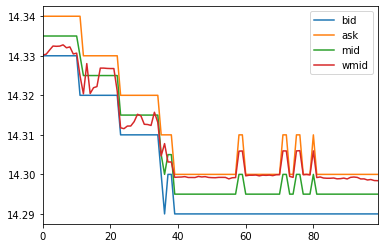

In [4]:
data[['bid','ask','mid','wmid']].plot()

# The mid vs. the weighted mid

The mid-price:
- Not a martingale (Bid-ask bounce)
- Medium frequency signal 
- Doesn't use volume at the best bid and ask prices. 

The weighted mid-price:
- Uses the volume at the best bid and ask prices.
- High frequency signal
- Is quite noisy, particularly when the spread widens to two ticks


# Desirable features of the Micro-Price

 $P_t^{micro}=F(M_t,I_t,S_t) = M_t+ G(I_t,S_t)$ 
- Martingale
- Computationally fast
- Better short term price predictions than the midprice or weighted midprice
- Should work for large tick stocks (like BAC) or small tick stocks (like CVX)

# Outline

1. General definition
2. A discrete Markov model
3. Data analysis
4. Conclusion

# Micro-price definition

Define
\begin{equation*}
P_t^{micro}=\lim_{n\to\infty} P_t^n
\end{equation*}
where the approximating sequence of martingale prices is given by
$$P^n_t=\mathbb{E} \left[  M_{\tau_n} |  I_t,S_t \right] $$

$\tau_1,...,\tau_n$ are (random) times when the mid-price $M_t$ changes
 
The micro-price is the expected mid-price in the distant future
 
In practice, the distant future is well captured by $P_t^6$, the expected mid price after 6 price moves.

# Main result


The $i$-th approximation to the micro-price can be written as
\begin{equation*}
P_t^{n} =  M_t + \sum_{k=1}^{n}g^k(I_t,S_t) 
\end{equation*}
where
$$g^1(I_t,S_t)= \mathbb{E}  \left[  M_{\tau_1} - M_t  | I_t, S_t \right] $$
and
$$
g^{n+1}(I_t,S_t)= \mathbb{E}\left[ g^n(I_{\tau_{1}},S_{\tau_{1}}) | I_{t},S_t\right], \forall j\geq 0
$$
can be computed recursively.

# Finite state Markov chain

- The imbalance takes discrete values $1\leq i_I \leq n$, 
- The spread takes discrete values $1\leq i_S \leq m$
- The mid-price changes takes values in $K =[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]$. 
- Define the state $X_t=(I_t,S_t)$ with discrete values $1\leq i \leq nm$

# Computing $g^1$

The first step approximation to the micro-price 
\begin{align*}
g^1(i) = &  \mathbb{E} \left[M_{\tau_{1}}- M_{t} | X_t= i \right] \\
= {}& \big(1-Q\big)^{-1}R^1\underline{k}
\end{align*}

Where
$$Q_{ij} := \mathbb{P}(M_{t+1}- M_t =0 \wedge X_{t+1}=j | X_t= i)$$
are the transition probabilities for transient states (mid price does not move) 

$$R^1_{ik} := \mathbb{P}(M_{t+1}- M_t =k | X_t = i)$$ are the transition probabilities into absorbing states (mid price does move) 

and $\underline{k}=[-0.01 \quad -0.005 \quad 0.005 \quad 0.01]^T$ 

# Computing $g^{i+1}$


We can compute recursively
\begin{align*}
g^{n+1}=  B g^n
\end{align*}
where $B:=\big(1-Q\big)^{-1}R^2$

and $R^2$ is a new matrix of absorbing states
\begin{align*}
R^2_{ik} := {}& \mathbb{P}(M_{t+1}- M_t \neq 0 \wedge I_{t+1}=k  | I_t = i)
\end{align*}

# Does the micro-price converge?

Yes. But we have to appropriately symmetrize the data.

Technical conditions are available in the paper.

# Data analysis on BAC and CVX

# Estimation

1. On every quote, compute $I_t, S_t, (M_{t+1}-M_t)$, after having discretized the state space
2. Symmetrize the data, by making a copy where $I^2_t=n-I_t, S^2_t=S_t, (M^2_{t+1}-M^2_t)=-(M_{t+1}-M_t)$
3. Estimate transition probability matrices $Q, R^1, R^2$


# Computation

Compute the first micro-price adjustment:
$$p^{1}-M = g^1 = \big(1-Q\big)^{-1}R^1\underline{k}$$
Use our recursive formula to compute the 6th micro-price adjustment:
$$p^{6}-M = g^1+g^2+ \ldots +g^6 = g^1 + B g^1 + \ldots + B^5 g^1 $$
In practice this converges after 6 price moves

In [5]:
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

In [6]:
def mirror_dynamics(df, n_imb):
    ''' Mirror state of order book and price dynamics '''
    dfm = df.copy(deep=True)
    mid0 = df['mid'].iloc[0]
    dfm[['bs', 'as']] = df[['as', 'bs']]
    dfm[['bid', 'ask']] = 2 * mid0 - df[['ask', 'bid']]
    dfm['imb'] = 1.0 - df['imb']
    dfm['imb_bucket'] = (n_imb-1) - df['imb_bucket']
    dfm['next_imb_bucket'] = (n_imb-1) - df['next_imb_bucket']
    dfm['dM'] = -df['dM']
    return dfm

def prep_data_sym(data, n_imb, dt, n_spread):
    ''' Discretize and symmetrize data '''
    T = data.copy()
    misc = {}

    # ticksize:= min spread>0, 2 decimal places.
    spread = T['ask'] - T['bid']
    ticksize = np.round(min(spread.loc[spread>0]), 2)
    misc['ticksize'] = ticksize
    
    # Spread is a multiple of ticksize (discretize)
    T['spread'] = np.round((T['ask'] - T['bid']) / ticksize) * ticksize # find closest discrete tick.
    T['mid'] = 0.5 * (T['bid'] + T['ask'])
    # Filter out spreads that are outside discretized bounds. (wonky?)
    LB, UB = (0, n_spread * ticksize)
    mask = (LB < T['spread']) & (T['spread'] <= UB)
    T = T.loc[mask]
    T['imb'] = T['bs'] / (T['bs'] + T['as'])
    
    # Buckets must be symmetric around imb=0.5, due to mirroring the data and buckets later.
    low_edge = np.amin([T['imb'].min(), 1.0-T['imb'].max()])
    edges = np.linspace(low_edge, 1.0 - low_edge, n_imb + 1)
    T['imb_bucket'], bins = pd.cut(T['imb'], edges, include_lowest=True, retbins=True, labels=False)    
    misc['imb_bucket_bins'] = bins
    
    # Step ahead state variables.
    T[['next_mid', 'next_spread', 'next_time', 'next_imb_bucket']] = T[['mid', 'spread', 'time', 'imb_bucket']].shift(-dt)

    # Step ahead change in mid price. Mid price has half a tick resolution 0.5*(bid + ask), when either bid or ask changes.
    mid_tsize = 0.5 * ticksize
    T['dM'] = np.round((T['next_mid'] - T['mid']) / mid_tsize) * mid_tsize
    
    # Numerical reason to cover the bound by epsilon factor?
    mask = (T['dM'].abs() <= ticksize*1.1)
    T = T.loc[mask]
    
    # Symetrize data => 2x data (I.e. assume same dynamics for up and down moves)
    T2 = mirror_dynamics(T, n_imb)
    T2['mirrored'] = True
    T['mirrored'] = False
    T3 = pd.concat([T, T2], axis=0, sort=False)
    T3.reset_index(inplace=True, drop=True)    

    return T3, misc

In [7]:
def full_stspace(T):
    ''' Get all visited unique states. '''
    def value_union(columns):
        return np.sort(np.unique(T[columns].drop_duplicates().to_numpy().flatten()))

    spread_states = value_union(columns=['spread', 'next_spread'])
    imb_states = value_union(columns=['imb_bucket', 'next_imb_bucket'])
    dM_states = np.sort(T['dM'].unique())
    return {'spread':spread_states, 'imb_bucket':imb_states, 'dM':dM_states}

def stspace_pd_index(stspace):
    ''' Create Markov chain matrix DataFrame indices.'''
    spr_imb = pd.MultiIndex.from_product([stspace['spread'], stspace['imb_bucket']], names=['spread', 'imb_bucket'])
    nxt_spr_imb = spr_imb.copy().set_names(names=['next_spread', 'next_imb_bucket'])
    dM = pd.Index(stspace['dM'], name='dM')
    return {'spr_imb':spr_imb, 'nxt_spr_imb':nxt_spr_imb, 'dM':dM}

def estimate(T):
    st_idx = stspace_pd_index(full_stspace(T))

    # === Transition matrix {spread, imb_bucket} → {next_spread, next_imb_bucket, mid_change} ===
    # Get counts
    trans = T.pivot_table(index=['spread', 'imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket', 'dM'], 
                     fill_value=0,
                     aggfunc='size')
    
    # Get mean MLE estimates
    trans = trans.divide(trans.sum(axis=1), axis=0)

    # Mask for absorbed transitions (mid price change occurs)
    absorb = trans.columns.get_level_values('dM') != 0.0
    
    # No absorb transitions, collapse (sum) mid change states {spread, imb_bucket} → {next_spread, next_imb_bucket, dM==0}.
    Q = trans.loc[:, ~absorb].sum(axis=1, level=['next_spread', 'next_imb_bucket'])
    Q = Q.reindex(index=st_idx['spr_imb'], columns=st_idx['nxt_spr_imb'], fill_value=0.0)

    # Absorb transitions, collapse (sum) all but mid_change states {spread, imb_bucket} → {dM!=0}.
    R1 = trans.loc[:, absorb].sum(axis=1, level=['dM'])
    R1 = R1.reindex(index=st_idx['spr_imb'], columns=st_idx['dM'], fill_value=0.0)
    SHOW_K0_STATE = False # Whether to show K=0 as a state (cosmetic)
    if not SHOW_K0_STATE:
        R1 = R1.loc[:, ~np.isclose(R1.columns.get_level_values('dM'), 0.0)]

    # Absorb transitions, collapse (sum) all next_spreads and next_imb into one per dM {spread, imb_bucket} → {next_spread, next_imb_bucket, dM!=0}.
    R2 = trans.loc[:, absorb].sum(axis=1, level=['next_spread', 'next_imb_bucket'])
    R2 = R2.reindex(index=st_idx['spr_imb'], columns=st_idx['nxt_spr_imb'], fill_value=0.0)

    # Jump sizes
    K = st_idx['dM'].to_numpy()
    if not SHOW_K0_STATE:
        K = K[K!=0.0]
    eye = np.eye(Q.shape[0])
    G1 = np.linalg.inv(eye - Q) @ R1 @ K # inv() converts DataFrame into ndarray, so pandas index is gone here.
    G1.index = Q.index # so we set it back.
    B = np.linalg.inv(eye - Q) @ R2
    B.index = Q.index
    Q2 = Q.copy()
    
    return G1, B, Q, Q2, R1, R2, K

In [8]:
COLOR_CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

def get_asymtotics(G1, B):
    '''
    P_k = M + sum_0^{k-1}(B^i) * G1
    Gstar := lim(P_k - M)
    '''
    vv, ee = np.linalg.eig(B)
    unit_idx = np.argmax(vv)
    Bstar = np.real(np.outer(ee[:, unit_idx], np.linalg.inv(ee)[unit_idx]))
    Bstar = pd.DataFrame(data=Bstar, index=B.index, columns=B.columns)
    vv[unit_idx] = 0.0
    vvgeosum = vv/(1 - vv)
    #vvgeosum = (vv - vv**(order))/(1 - vv)
    Gsum = ee @ np.diag(vvgeosum) @ np.linalg.inv(ee)
    Gstar = (G1 + Gsum @ G1).to_numpy().real
    Gstar = pd.Series(data=Gstar, index=G1.index)
    return Gstar, Bstar

def calc_price_adj(G1, B, order='stationary'):
    ''' Calculate Price Adjustments.'''
    if order == 'stationary':
        return get_asymtotics(G1, B)
    elif isinstance(order, int): # Crude method,.. if num issues, use the eigendecomp for non asymtotic.
        Bstar = pd.DataFrame(data=mpow(B, order), index=B.index, columns=B.columns)
        Gstar = sum(mpow(B, i) for i in range(order)) @ G1
        Gstar = pd.Series(data=Gstar, index=B.index)
        return Gstar, Bstar
    else:
        raise ValueError()
    
def plot_Gstar(ticker, Gstar, misc):
    ''' Plot Micro Price Adjustment'''
    bin_edges = misc['imb_bucket_bins']
    bucket_mid = 0.5*(bin_edges[:-1] + bin_edges[1::])
    
    plt.figure()
    plt.title('{} adjustments'.format(ticker))
    
    plt.plot([0, 1], [0, 0], label='Mid adj', color=COLOR_CYCLE[0])
    plt.plot([0, 1], [-0.5, 0.5], label='Weighted mid adj', color=COLOR_CYCLE[1])
    
    for i, (sprd, grp) in enumerate(Gstar.groupby(level='spread')):
        lbl = 'spread = {} tick'.format(i+1)
        plt.plot(bucket_mid, grp / sprd, label=lbl, marker='o', linewidth=2.0, color=COLOR_CYCLE[2+i])
        #y_step_edges = np.append(grp, grp[-1]) / sprd
        #plt.step(bin_edges, y_step_edges, label='', where='post', color=COLOR_CYCLE[2+i])
    
    plt.ylim(-0.5, 0.5)
    plt.yticks(np.linspace(-0.5, 0.5, 10+1))
    plt.xlim([0, 1])
    plt.xticks(np.linspace(0, 1, 10+1))
    plt.legend(loc='upper left')
    plt.xlabel('Imbalance')  
    plt.ylabel('Price Adj norm. by spread')
    plt.grid()
    plt.show()
    
def plot_Bstar(B_pmf, misc):
    ''' Plot stationary transition probability mass function '''
    bin_edges = misc['imb_bucket_bins']
    bucket_mid = 0.5*(bin_edges[:-1] + bin_edges[1::])

    for i, (next_sprd, marginal_pdf) in enumerate(B_pmf.groupby(level='next_spread')):
        lbl = '$s$ = {} tick'.format(i+1)
        plt.plot(bucket_mid, marginal_pdf, label=lbl, marker='o', lw=0.5, color=COLOR_CYCLE[2+i])
        plt.vlines(bucket_mid, 0, marginal_pdf, color=COLOR_CYCLE[2+i], lw=2.0)
        ticks = next_sprd / misc['ticksize']
        print('pmf(s = {:.0f} tick) = {:.2f}'.format(ticks, marginal_pdf.sum()))

    plt.xlim([0, 1])
    plt.xticks(np.linspace(0, 1, 11))

    plt.legend(loc='upper left', fontsize=11)
    plt.title('stationary transition $pmf(s, I)$')
    plt.xlabel('Imbalance $I$', fontsize=11)
    plt.ylabel('Density', fontsize=11)
    plt.grid()
    plt.show()    

# BAC

In [9]:
n_imb = 10
n_spread = 2
dt = 1
data = get_df('BAC')
ticker = 'BAC'
T, misc = prep_data_sym(data, n_imb, dt, n_spread)

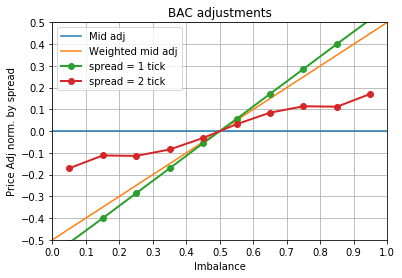

In [10]:
G1, B, Q, Q2, R1, R2, K = estimate(T)
Gstar, Bstar = calc_price_adj(G1, B, order='stationary')
plot_Gstar(ticker, Gstar, misc)

pmf(s = 1 tick) = 0.69
pmf(s = 2 tick) = 0.31


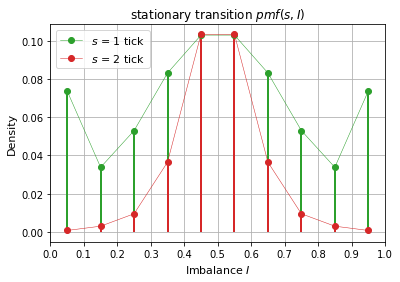

In [11]:
Bstar_pdf = Bstar.iloc[0]  # ~= np.linalg.matrix_power(B,10).iloc[0]
Bstar_pdf = pd.Series(np.linalg.matrix_power(B, 5)[0], index=B.columns)
plot_Bstar(Bstar_pdf, misc)

# CVX

In [12]:
n_imb = 4
n_spread = 4
dt = 1
data = get_df('CVX')
ticker = 'CVX'
T, misc = prep_data_sym(data, n_imb, dt, n_spread)

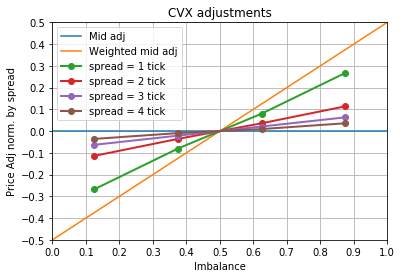

In [13]:
G1, B, Q, Q2, R1, R2, K = estimate(T)
Gstar, Bstar = calc_price_adj(G1, B, order='stationary')
plot_Gstar(ticker, Gstar, misc)

pmf(s = 1 tick) = 0.23
pmf(s = 2 tick) = 0.40
pmf(s = 3 tick) = 0.27
pmf(s = 4 tick) = 0.10


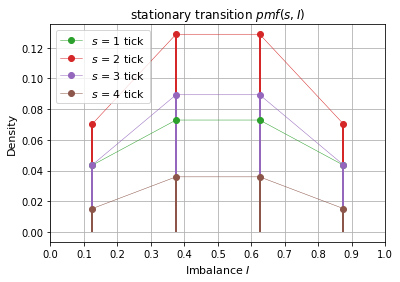

In [14]:
Bstar_pdf = Bstar.iloc[0]  # ~= np.linalg.matrix_power(B,10).iloc[0]
plot_Bstar(Bstar_pdf, misc)

# Summary

1. The micro-price is the expected mid-price in the distant future
2. In practice, the distant future is adequately approximated by $\tau^6$ the time of the 6th mid price move
3. Paper provides evidence that the micro-price is a good predictor of future mid prices
3. Micro-price can fit very different microstructures
4. Micro-price is horizon independent
5. Micro-price seems to most often live between the bid and the ask